In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

#importing the visulization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Ignoring values
import warnings
warnings.filterwarnings('ignore')

# Multicolinearity test libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Model selection librarries
from sklearn.model_selection import cross_val_score,train_test_split, KFold, GridSearchCV

#ML modelsLibraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor

import xgboost
from xgboost import XGBRegressor

#model evaluation libraries
from sklearn.metrics import mean_squared_error,r2_score

### Importing the data:

In [2]:
df1= pd.read_excel("Medibuddy insurance data personal details (1) (2).xlsx")
df2 = pd.read_excel("Medibuddy Insurance Data Price (1) (2).xlsx")

### Checking both the dataframes for any discrepency in the data.

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Policy no.  1338 non-null   object
 1   children    1338 non-null   int64 
 2   smoker      1338 non-null   object
 3   region      1338 non-null   object
dtypes: int64(1), object(3)
memory usage: 41.9+ KB


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Policy no.      1338 non-null   object 
 1   age             1338 non-null   float64
 2   sex             1338 non-null   object 
 3   bmi             1338 non-null   float64
 4   charges in INR  1338 non-null   float64
dtypes: float64(3), object(2)
memory usage: 52.4+ KB


In [5]:
df1.isnull().sum()

Policy no.    0
children      0
smoker        0
region        0
dtype: int64

In [6]:
df2.isnull().sum()

Policy no.        0
age               0
sex               0
bmi               0
charges in INR    0
dtype: int64

### Both the dataframes do not have any missing values, hence they can be merged.

In [7]:
#MERGING THE BOTH DATAFRAMES ON POLICY NO.

df_merge = pd.merge(df2, df1, how='inner', on='Policy no.')

In [8]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Policy no.      1338 non-null   object 
 1   age             1338 non-null   float64
 2   sex             1338 non-null   object 
 3   bmi             1338 non-null   float64
 4   charges in INR  1338 non-null   float64
 5   children        1338 non-null   int64  
 6   smoker          1338 non-null   object 
 7   region          1338 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 94.1+ KB


In [9]:
df_merge.isnull().sum()

Policy no.        0
age               0
sex               0
bmi               0
charges in INR    0
children          0
smoker            0
region            0
dtype: int64

In [10]:
df_merge.head()

,Policy no.,age,sex,bmi,charges in INR,children,smoker,region
0,PLC156898,19.0,female,27.900,16884.92400,0,yes,southwest
1,PLC156907,18.0,male,33.770,1725.55230,1,no,southeast
2,PLC156916,28.0,male,33.000,4449.46200,3,no,southeast
3,PLC156925,33.0,male,22.705,21984.47061,0,no,northwest
4,PLC156934,32.0,male,28.880,3866.85520,0,no,northwest


FROM THE DATA WE CAN SEE THAT THERE ARE THREE CATEGORICAL VARIABLES('SEX','SMOKER','REGION'), HENCE THEY AHVE TO CONVERTED TO NUMRICAL TYPE.
THIS IS ACHIVED BY CARRYING OUT ONE HOT ENCODING.

In [11]:
ohe_sex = pd.get_dummies(df_merge['sex'], drop_first=True)
ohe_smoker = pd.get_dummies(df_merge['smoker'], drop_first=True)
ohe_region = pd.get_dummies(df_merge['region'], drop_first=True)

In [12]:
data = df_merge.copy()

In [13]:
data['male']= ohe_sex
data[['northwest','southeast','southwest']]=ohe_region
data['smoker'] = ohe_smoker

In [14]:
data.drop(['sex','region','Policy no.'], axis=1, inplace=True)

In [15]:
data.head()

,age,bmi,charges in INR,children,smoker,male,northwest,southeast,southwest
0,19.0,27.900,16884.92400,0,1,0,0,0,1
1,18.0,33.770,1725.55230,1,0,1,0,1,0
2,28.0,33.000,4449.46200,3,0,1,0,1,0
3,33.0,22.705,21984.47061,0,0,1,1,0,0
4,32.0,28.880,3866.85520,0,0,1,1,0,0


## EDA(Exploratory Data Analysis)

In [16]:
data.describe()

,age,bmi,charges in INR,children,smoker,male,northwest,southeast,southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265,1.094918,0.204783,0.505232,0.242900,0.272048,0.242900
std,14.049960,6.098187,12110.011237,1.205493,0.403694,0.500160,0.428995,0.445181,0.428995
min,18.000000,15.960000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.296250,4740.287150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,9382.033000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,51.000000,34.693750,16639.912515,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,64.000000,53.130000,63770.428010,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Checking for Outliers:

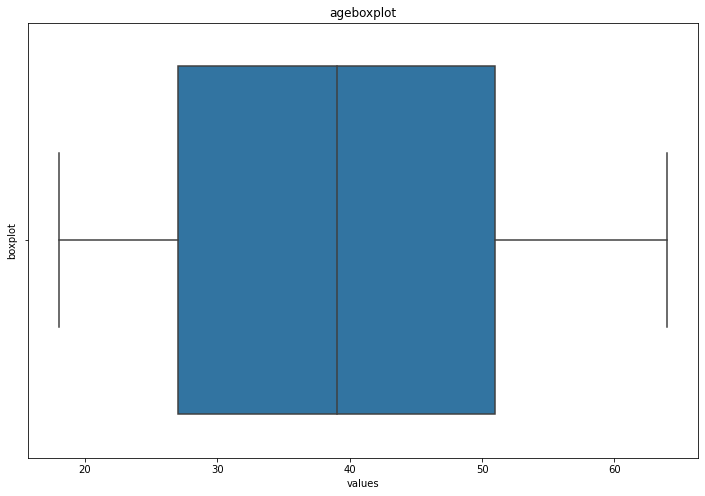

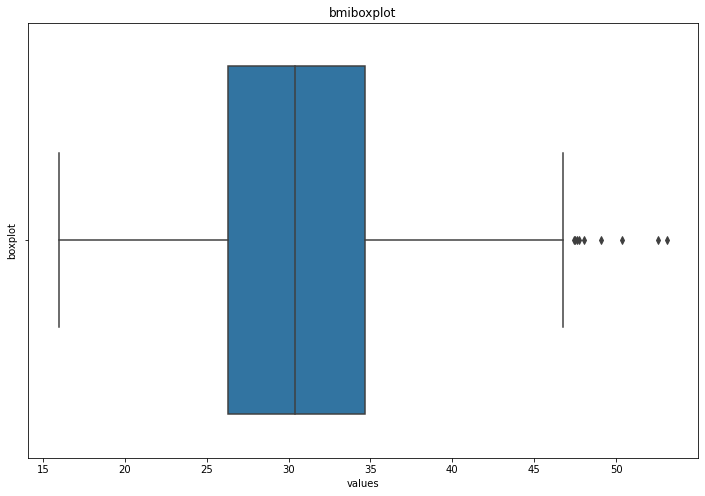

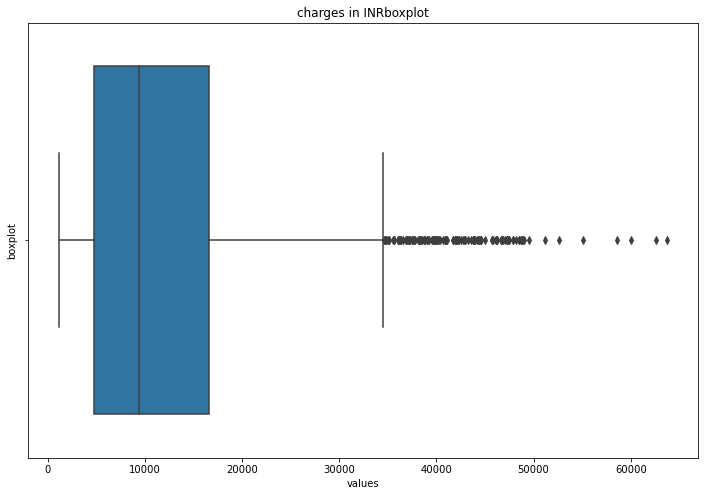

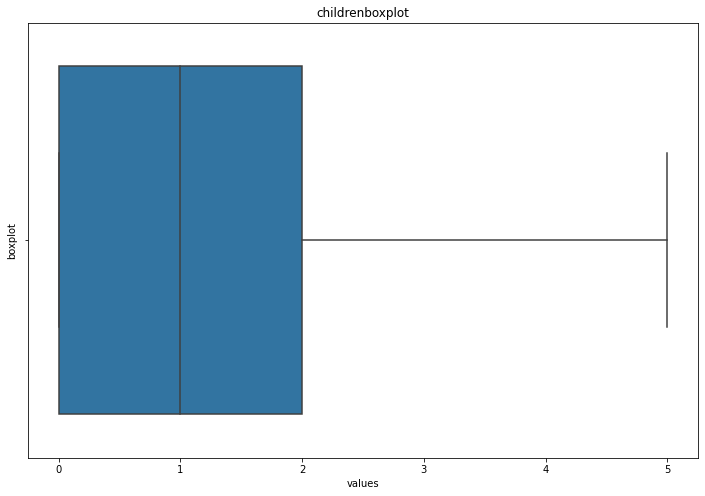

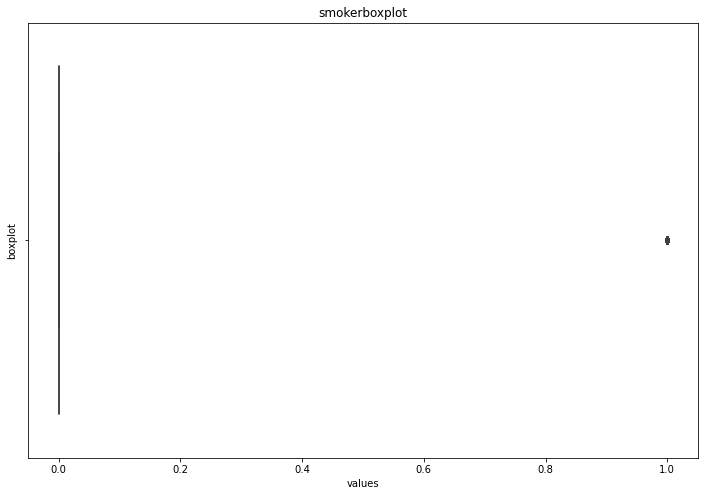

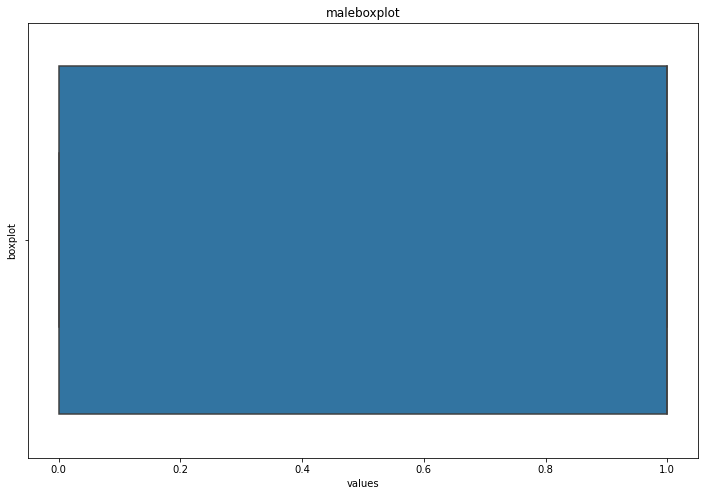

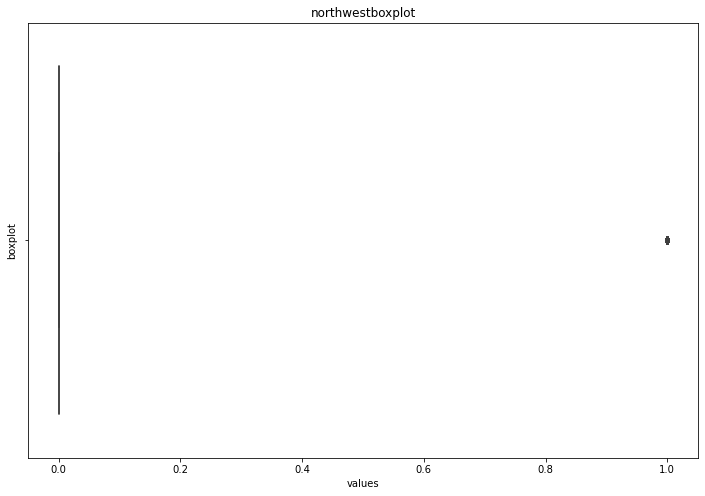

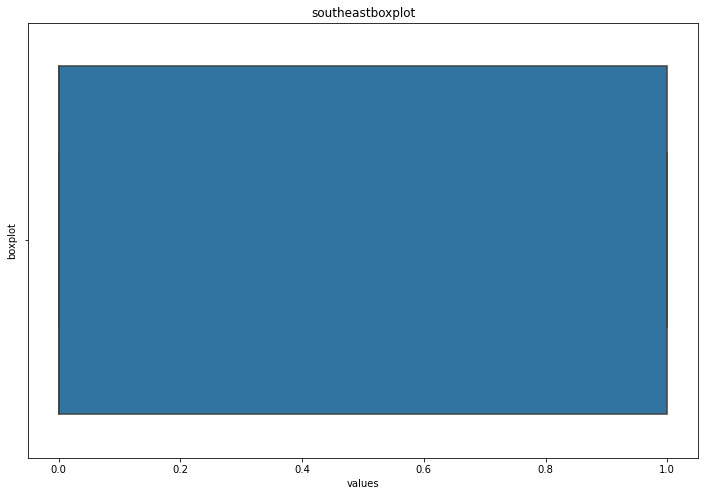

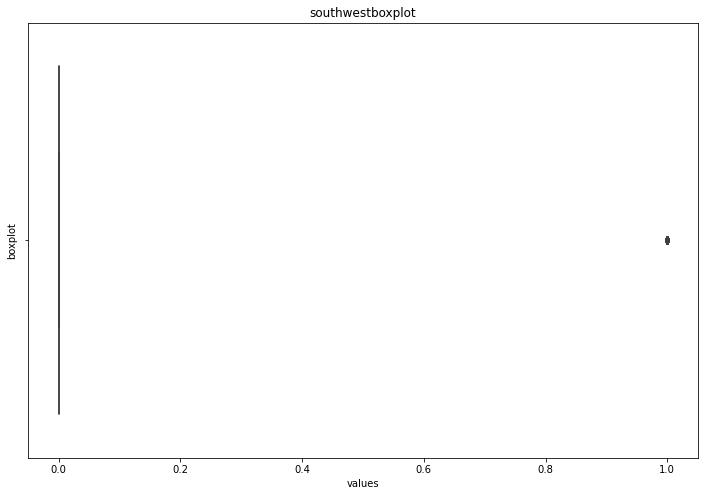

In [17]:
for col in data.columns:
    f, ax1=plt.subplots(figsize= (12,8))
    sns.boxplot(data[col])
    plt.title(col + "boxplot")
    plt.xlabel("values")
    plt.ylabel("boxplot")

FROM THE BOX PLOT WE CAN SEE THAT "BMI" and "CHARGES IN INR" COLUMNS HAS THE OUTLIERS IN THE UPPER WHISKER REGION

### MULTICOLINEARITY TEST:
- Corelation matrix or heat map(stage 1)

<AxesSubplot:>

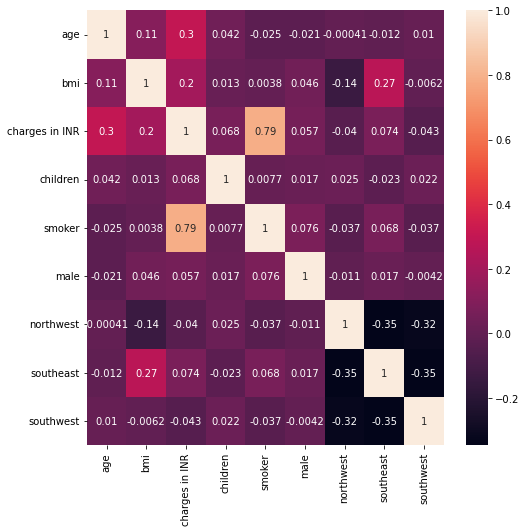

In [18]:
cor = data.corr()
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cor, annot =True)

- AS A GENERAL THUMB OF RULE IF THE CORRELATION VALUE IS GREATER THAN 0.3 OR 30%, THEN WE CAN SAY THAT THERE IS A CHANCE OF MULTICOLINARITY BETWEEN COLUMNS IN THE DATA.

### MULTICOLINEARITY TEST:
variation inflation factor(stage 2)

In [19]:
vif = pd.DataFrame()
features = data.drop('charges in INR', axis=1)
vif['features_name'] = features.columns
vif['VIF']= [variance_inflation_factor(features,i) for i in range(features.shape[1])]
vif

,features_name,VIF
0,age,7.686965
1,bmi,11.358443
2,children,1.809930
3,smoker,1.261233
4,male,2.003185
5,northwest,1.890281
6,southeast,2.265564
7,southwest,1.960745


FROM THE ANALYSIS ABOVE WE CAN SEE THAT ONLY TWO COLUMNS HAVE VIF > 5, SO WE CAN SAY THAT MULTICOLINEARITY DOESNOT EXISTS.

### MODEL BUILDING:
- test-train-split
- stratified kfold cross validation
- hyperparametre tunning

In [20]:
X = data.drop('charges in INR', axis=1)
y = data['charges in INR']

In [21]:
def model_builder(model):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    R2_score = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    return(type(model).__name__,R2_score,RMSE)

In [22]:
mod = [LinearRegression(), Lasso(), Ridge(),SVR(),DecisionTreeRegressor(), RandomForestRegressor(), AdaBoostRegressor(),
       GradientBoostingRegressor(),XGBRegressor(), KNeighborsRegressor()]
res = []
for i in range(len(mod)):
    res.append(model_builder(mod[i]))

my_res = pd.DataFrame(res, columns=['Model_name','R2_score','RMSE'])

In [23]:
my_res.sort_values('R2_score', ascending=False)

,Model_name,R2_score,RMSE
7,GradientBoostingRegressor,0.839154,4691.906156
5,RandomForestRegressor,0.825009,4893.861323
6,AdaBoostRegressor,0.811622,5077.607997
8,XGBRegressor,0.787717,5390.160723
2,Ridge,0.734112,6032.449301
1,Lasso,0.733777,6036.243447
0,LinearRegression,0.733707,6037.036541
4,DecisionTreeRegressor,0.610380,7302.383647
9,KNeighborsRegressor,0.036631,11482.600479
3,SVR,-0.185062,12735.453986


### K- Fold Cross Validation

In [28]:
models = [LinearRegression(), Lasso(), Ridge(),SVR(),DecisionTreeRegressor(), RandomForestRegressor(), AdaBoostRegressor(),
       GradientBoostingRegressor(),XGBRegressor(), KNeighborsRegressor()]

col_names = ['model_names','CV_accuracy','CV_STD']
results = pd.DataFrame(columns=col_names)

for i in range(len(models)):
    kfold= KFold(n_splits=10, shuffle=True,random_state=1)
    cv = cross_val_score(models[i],X,y,cv=kfold)
    mean_score = np.mean(cv)
    std_score = np.std(cv)
    results.loc[len(results)] = [type(models[i]).__name__,mean_score,std_score]
    
results.sort_values('CV_accuracy', ascending = False)

,model_names,CV_accuracy,CV_STD
7,GradientBoostingRegressor,0.857154,0.026958
5,RandomForestRegressor,0.832039,0.025501
6,AdaBoostRegressor,0.817429,0.021063
8,XGBRegressor,0.811417,0.025940
2,Ridge,0.743785,0.037570
1,Lasso,0.743760,0.037859
0,LinearRegression,0.743754,0.037876
4,DecisionTreeRegressor,0.702034,0.060420
9,KNeighborsRegressor,0.127501,0.111945
3,SVR,-0.108291,0.046787


IF WE COMPARE THE RESULTS OF ALL THE MODELS WITH AND WITHOUT THE K-FOLD CROSS VALIDATION THERE IS AN INCREASE OF 3% IN THE ACCURACY

### HYPERPARAMETRE TUNNING:

In [29]:
param_las= {'alpha': [1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
param_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
param_dtr = {'max_depth':[3,5,7,9,10,12,14,16],'max_features':['auto','log2','sqrt',2,3,4,5,6]}
param_svr = {'gamma':['scale','auto'],'C':[0.5,1]}
param_adb = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
param_gb  = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
param_xgb = {'eta':[0.0,0.1,0.2,0.3,0.4,0.5],'max_depth':[3,5,7,9,10],'gamma':[0,10,20,30,40,50,60,70,80,90,100,200,300,400,500],'reg_lambda':[0,1]}
param_RF  = {'max_depth':[3,5,7,9,10,12,14,16],'max_features':['auto','log2','sqrt',2,3,4,5,6]}


tune_las = GridSearchCV(Lasso(),param_las, cv=10)
tune_rid = GridSearchCV(Ridge(),param_las, cv=10)
tune_knn = GridSearchCV(KNeighborsRegressor(),param_knn, cv=10)
tune_dtr = GridSearchCV(DecisionTreeRegressor(),param_dtr, cv=10)
tune_svr = GridSearchCV(SVR(),param_svr, cv=10)
tune_gb = GridSearchCV(GradientBoostingRegressor(),param_gb, cv=10)
tune_adb = GridSearchCV(AdaBoostRegressor(),param_adb, cv=10)
tune_xgb = GridSearchCV(XGBRegressor(),param_xgb, cv=10)
tune_RFR = GridSearchCV(RandomForestRegressor(),param_RF, cv=10)

tune_las.fit(X,y)
tune_rid.fit(X,y)
tune_knn.fit(X,y)
tune_dtr.fit(X,y)
tune_svr.fit(X,y)
tune_gb.fit(X,y)
tune_adb.fit(X,y)
tune_xgb.fit(X,y)
tune_RFR.fit(X,y)

tune = [tune_las,tune_rid, tune_knn,tune_dtr,tune_svr,tune_adb,tune_gb,tune_xgb,tune_RFR]
models = ['Lasso','Ridge','KNN','Decision Tree','SVM','ADA Boost','Gradient Boosting','XG Boost','Random Forrest']

for i in range(len(tune)):
    print("model :",models[i])
    print("best parametre :", tune[i].best_params_)
    
    

model : Lasso
best parametre : {'alpha': 30}
model : Ridge
best parametre : {'alpha': 1}
model : KNN
best parametre : {'n_neighbors': 7}
model : Decision Tree
best parametre : {'max_depth': 5, 'max_features': 'auto'}
model : SVM
best parametre : {'C': 1, 'gamma': 'scale'}
model : ADA Boost
best parametre : {'learning_rate': 0.1}
model : Gradient Boosting
best parametre : {'alpha': 0.1}
model : XG Boost
best parametre : {'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'reg_lambda': 1}
model : Random Forrest
best parametre : {'max_depth': 5, 'max_features': 5}


### K-Fold Cross Validation Post Hyperparametre Tuning:

In [37]:
models = [LinearRegression(), Lasso(alpha=30), Ridge(alpha=1),SVR(C=1,gamma='scale'),DecisionTreeRegressor(max_depth=5,max_features='auto'), RandomForestRegressor(max_depth=5,max_features=5), AdaBoostRegressor(learning_rate=0.1),
       GradientBoostingRegressor(alpha=0.1,loss='squared_error',n_estimators=40),XGBRegressor(eta=0.1,gamma=0,max_depth=3,reg_lambda=1), KNeighborsRegressor(n_neighbors=7)]

col_names = ['model_names','CV_accuracy','CV_STD']
results_hyper = pd.DataFrame(columns=col_names)

for i in range(len(models)):
    kfold= KFold(n_splits=10, shuffle=True,random_state=1)
    cv = cross_val_score(models[i],X,y,cv=kfold)
    mean_score = np.mean(cv)
    std_score = np.std(cv)
    results_hyper.loc[len(results_hyper)] = [type(models[i]).__name__,mean_score,std_score]
    
results_hyper.sort_values('CV_accuracy', ascending=False)

,model_names,CV_accuracy,CV_STD
7,GradientBoostingRegressor,0.861377,0.027283
5,RandomForestRegressor,0.860194,0.027458
8,XGBRegressor,0.859274,0.027115
4,DecisionTreeRegressor,0.851477,0.021819
6,AdaBoostRegressor,0.829968,0.022896
1,Lasso,0.743900,0.037465
2,Ridge,0.743785,0.037570
0,LinearRegression,0.743754,0.037876
9,KNeighborsRegressor,0.135081,0.093737
3,SVR,-0.108291,0.046787


In [36]:
param_gb  = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
            'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
            'n_estimators': [10,10,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500],
            }

decison_tune = GridSearchCV(GradientBoostingRegressor(), param_gb, cv=10)
decison_tune.fit(X,y)
print(decison_tune.best_params_)

{'alpha': 0.1, 'loss': 'squared_error', 'n_estimators': 40}


FROM POST HYPERPARAMETER TUNING WE CAN SEE THAT THERE IS SIGNIFICANT INCREASE IN THE PERFORMANCE OF SOME ALGORITHMS LIKE:
- DECISION TREE
- XG BOOST

In [40]:
model_builder(GradientBoostingRegressor(alpha=0.1,loss='squared_error',n_estimators=40))

('GradientBoostingRegressor', 0.8479797407101457, 4561.363487650621)

### Dumping the model using PICKLE:

In [108]:
import pickle

In [109]:
Regressor = GradientBoostingRegressor(alpha=0.1,loss='squared_error',n_estimators=40)

In [111]:
Regressor.fit(X,y)

GradientBoostingRegressor(alpha=0.1, n_estimators=40)

In [112]:
pickle.dump(Regressor, open('model.pkl','wb'))

In [113]:
model = pickle.load(open('model.pkl','rb'))

In [115]:
#test_=[20,19,0,0,0,0,0,0]
#Regressor.predict(np.reshape(test_,(1,8)))

array([2731.34889705])

In [114]:
X.head()

,age,bmi,children,smoker,male,northwest,southeast,southwest
0,19.0,27.900,0,1,0,0,0,1
1,18.0,33.770,1,0,1,0,1,0
2,28.0,33.000,3,0,1,0,1,0
3,33.0,22.705,0,0,1,1,0,0
4,32.0,28.880,0,0,1,1,0,0
